### Here, I will train an Isolation Forest model on the million transaction dataset

In [2]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import sys
import os

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

# SCRIPT
sys.path.append(os.path.abspath(".."))
from scripts import conversions

### Preprocess (sanity check)

In [18]:
df = pd.read_csv('../data/full_transactions.csv')
df

,hash,sender,recipient,value,gas_used,gas_price,timestamp,value_zscore
0,0x06dc5006e9cc13418808a35b5a6fb91378eb78c236db...,0x675bB023e268dCC43F543620577bCacB73047f08,0x5dC62cea20B0E7c3607aDCc61a885Ff9369dbc60,0.000000,223837,180.411926,2025-02-14 10:16:10,-0.011788
1,0x689d1453646e621d664836655d869d7301b8c7bcd1d4...,0x1ba98272731f1Ab5cC33a02F88694C39916E26dF,0x51C72848c68a965f66FA7a88855F9f7784502a7F,0.000000,153985,81.237520,2025-02-14 10:16:10,-0.011788
2,0x3057779542c82c2ae3f1b52b6739afe82719a61ad26c...,0x5d1783ddbb657fdf6FcC2eF5B6796Ac0DdeEb6e3,0x68d3A973E7272EB388022a5C6518d9b2a2e66fBf,0.000000,223550,65.091946,2025-02-14 10:16:11,-0.011788
3,0x0c664ea5c27efb322c1dc20c2a830b97a33fbd82b027...,0x3f22f60936F4f5D1E96cEdEb44beE66d0Cd7c220,0x98C3d3183C4b8A650614ad179A1a98be0a8d6B8E,0.000000,500002,63.063619,2025-02-14 10:16:11,-0.011788
4,0x1b386bb2f08f57a5287640e09e2f3640798a58d69a3a...,0x24f7eF98522dd61D529464f67BB3ffe96eA8AFC2,0x5dC62cea20B0E7c3607aDCc61a885Ff9369dbc60,0.000000,252997,47.995919,2025-02-14 10:16:11,-0.011788
...,...,...,...,...,...,...,...,...
1000460,0x8cbf01dc0bbebe854a64ccd7e9ccee8876c95ee30cfb...,0x5698D4ec03802438Bce268b02eb3817B8C3C2b3f,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,0.000000,45758,1.919426,2025-02-17 06:06:35,-0.011788
1000461,0xb0fac9da7e21836663a05e8bcfd429a64e66160f10d7...,0x5baBE600b9fCD5fB7b66c0611bF4896D967b23A1,0xf45AFF520a8Ebe59f513719fc78b164e375Dd1f4,0.007562,21000,1.917395,2025-02-17 06:06:35,-0.011718
1000462,0x488d4e454120b061f3a0c41008b90d1156737845d91a...,0x99719eacc100BD48D4dbEb96E990333a7601e5B8,0x65c55F33F9493E8702FEea89B4fA357283eD3841,0.000000,302687,1.917395,2025-02-17 06:06:35,-0.011788
1000463,0xcdda18972b9baf4310ce4be72d1ec91dc32bb2f02c6b...,0x6a0913BA185848c09250D3F40DFf29dC45530978,0xb965602E41Af7A92B3F4b48729736Aded9C94E47,0.000000,500000,1.913384,2025-02-17 06:06:35,-0.011788


In [21]:
def create_additional_features(df):
    df['gas_fee_ratio'] = df['gas_price'] / df['gas_used']
    df['txn_speed'] = df['gas_price'] * df['gas_used']

def train_isolation_forest(df, features, n_estimators, contamination, random_state=42):

    # Drop dupes/na (sanity check)
    print(f'Data count before cleaning: {len(df)}')
    df.dropna(inplace=True)
    df.drop_duplicates(subset=['hash'], inplace=True)
    print(f'Data count after cleaning: {len(df)}')

    df_features = df[features].copy()

    pipe = Pipeline([('scaler', StandardScaler()),
                     ('isolation_forest', IsolationForest(n_estimators=n_estimators,
                                                         contamination=contamination,
                                                         random_state=random_state))])
    
    df_results = df.copy()
    df_results['anomaly_score'] = pipe.fit_predict(df_features)

    num_anomalies = len(df_results[df_results['anomaly_score'] == -1])
    num_normal = len(df_results[df_results['anomaly_score'] != -1])
    print(f'Number of anomalies flagged: {num_anomalies}')
    print(f'Number of unflagged points: {num_normal}')

    scores = pipe.named_steps['isolation_forest'].decision_function(df_features)

    plt.figure(figsize=(10, 5))
    sns.histplot(scores, bins=50, kde=True, color='blue')
    plt.xlabel("Anomaly Score", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.title("Distribution of Anomaly Scores", fontsize=16, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    scores = pipe.named_steps['isolation_forest'].decision_function(df[features])
    print(f"Min: {np.min(scores)}\nMax: {np.max(scores)}\nMean: {np.mean(scores)}\nStd Dev: {np.std(scores)}")

    return df_results

def scatter_plot_anomalies(df):
    anomaly_values = df[df['anomaly_score'] == -1]['values']
    normal_values = df[df['anomaly_score'] != -1]['values']

    index_anomaly = anomaly_values.index
    index_normal = normal_values.index

    sns.set_style("whitegrid")

    plt.figure(figsize=(14, 7), facecolor="whitesmoke")

    plt.scatter(index_normal, normal_values, 
                linestyle='-', marker='o', 
                s=10, alpha=0.5, 
                color='gray', edgecolor="black", 
                label="Normal Transactions")

    plt.scatter(index_anomaly, anomaly_values, 
                linestyle='-', marker='o', 
                s=25, alpha=0.8, 
                color='red', edgecolor="black", 
                label="Anomalous Transactions")

    plt.yscale("log")
    plt.xticks(np.linspace(0, len(df), num=11, dtype=int), fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Transaction Index', fontsize=14, fontweight='bold')
    plt.ylabel('Transaction Value (Log Scale)', fontsize=14, fontweight='bold')
    plt.title('Anomalies vs. Normal Transactions', fontsize=16, fontweight='bold', color="black")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12, frameon=True, facecolor="whitesmoke", edgecolor="black", loc="upper right")
    plt.show()


### Traning on only value

Data count before cleaning: 1000465
Data count after cleaning: 1000465
Number of anomalies flagged: 9887
Number of unflagged points: 990578


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


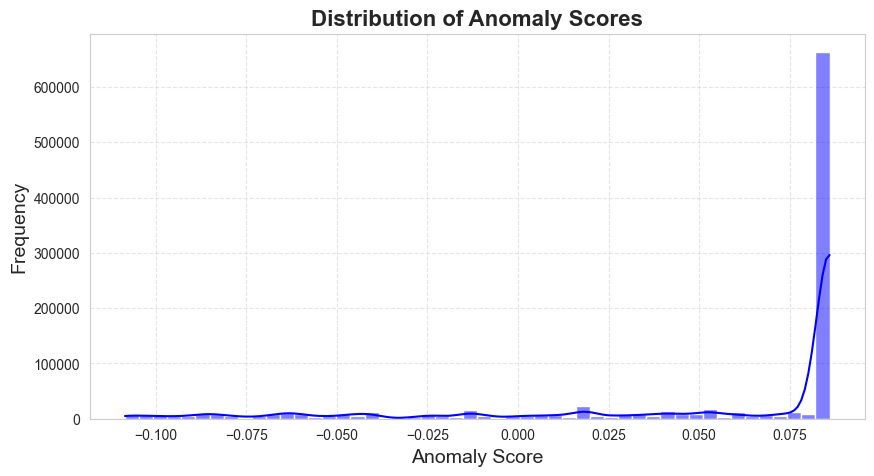

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


Min: -0.10849453050616686
Max: 0.08602457299182098
Mean: 0.054533381095211726
Std Dev: 0.054790667945445376


KeyError: 'values'

In [22]:
df_results = train_isolation_forest(df, ['value'], 100, .01)
scatter_plot_anomalies(df_results)

In [16]:
train_isolation_forest(df, df.columns, 100, .01)
scatter_plot_anomalies(df)

Data count before cleaning: 1000465
Data count after cleaning: 1000465


ValueError: could not convert string to float: '0x06dc5006e9cc13418808a35b5a6fb91378eb78c236dbec775f022c9af20cbd60'